In [6]:
import os
import torch
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

/Users/mpekey/miniconda3/envs/lightning/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [27]:
# PATH INFO
PROJ_DIR = '/Users/mpekey/Desktop/FlyVideo'
DATA_PATH = os.path.join(PROJ_DIR, 'Dataset')

# VIDEO INFO
FPS = 30
HEIGHT = 800
WIDTH = 1100

# MODEL INFO
MODEL_CHECKPOINT = "MCG-NJU/videomae-base"
BATCH_SIZE = 8

In [15]:
class_labels = ['Feeding', 'Grooming', 'Pumping']
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

### VideoMAE from HuggingFace

In [106]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(MODEL_CHECKPOINT)
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CHECKPOINT,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
    num_frames = 16 # Default is 16
)

Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: ['decoder.decoder_layers.0.attention.attention.v_bias', 'decoder.decoder_layers.1.output.dense.bias', 'decoder.decoder_layers.2.output.dense.weight', 'decoder.decoder_layers.2.layernorm_after.weight', 'decoder.decoder_layers.0.output.dense.weight', 'decoder.decoder_layers.1.layernorm_before.bias', 'decoder.decoder_layers.0.attention.attention.q_bias', 'decoder.head.bias', 'decoder.decoder_layers.2.attention.attention.query.weight', 'decoder.decoder_layers.3.intermediate.dense.bias', 'decoder.decoder_layers.3.layernorm_after.weight', 'decoder.decoder_layers.0.layernorm_after.weight', 'decoder.decoder_layers.1.layernorm_after.weight', 'encoder_to_decoder.weight', 'decoder.head.weight', 'decoder.decoder_layers.3.attention.attention.key.weight', 'decoder.decoder_layers.0.layernorm_before.bias', 'decoder.decoder_layers.1.intermediate.dense.weight', 'decoder.decoder_l

In [107]:
print('Img mean:', image_processor.image_mean, 'Img std:', image_processor.image_std)
print('Crop size:', image_processor.crop_size)
print(model.config.num_frames)

Img mean: [0.485, 0.456, 0.406] Img std: [0.229, 0.224, 0.225]
Crop size: {'height': 224, 'width': 224}
16


### Creating a Pytorchvideo Dataset with VideoMAE default configurations

In [118]:
# Image Preprocessing

mean = image_processor.image_mean
std = image_processor.image_std

if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]

crop_size = (height, width)


num_frames_to_sample = model.config.num_frames # 16 for VideoMAE
sample_rate = 8
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps
print('Clip Duration:', clip_duration, 'seconds')

Clip Duration: 4.266666666666667 seconds


In [119]:
basic_transforms = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(crop_size),
                    #RandomHorizontalFlip(p=0.5)
                ]
            ),
        ),
    ]
)

In [120]:
fly_dataset = pytorchvideo.data.labeled_video_dataset(data_path=DATA_PATH,
                                                      clip_sampler=pytorchvideo.data.make_clip_sampler('uniform', clip_duration),
                                                      transform=basic_transforms,
                                                      video_path_prefix='',
                                                      decode_audio=False)

### Analyzing Videos

In [131]:
print('Number of videos:', fly_dataset.num_videos)

Number of videos: 1383


In [132]:
sample_video = next(iter(fly_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [123]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name prob_49_1257801_1258536.avi
video_index 1272
clip_index 0
aug_index 0
label 2
Video label: Pumping


In [124]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    #kargs = {"duration": 0.25}
    kargs = {"duration": 3}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

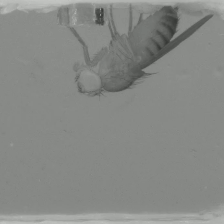

In [126]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [129]:
import matplotlib.pyplot as plt

def create_video_subplot(sample_video):

    video_tensor = sample_video["video"]
    video_tensor = video_tensor.permute(1, 0, 2, 3) # Frame x Channel x Height x Width
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

    for i, f in enumerate(frames):
        #print(int(i // ((len(frames)/2))), i%(len(frames)/2))
        axs_row = int(i // ((len(frames)/4)))
        axs_col = int(i%(len(frames)/4))
        axs[axs_row, axs_col].imshow(f)
        axs[axs_row, axs_col].axis('off')
    plt.show()

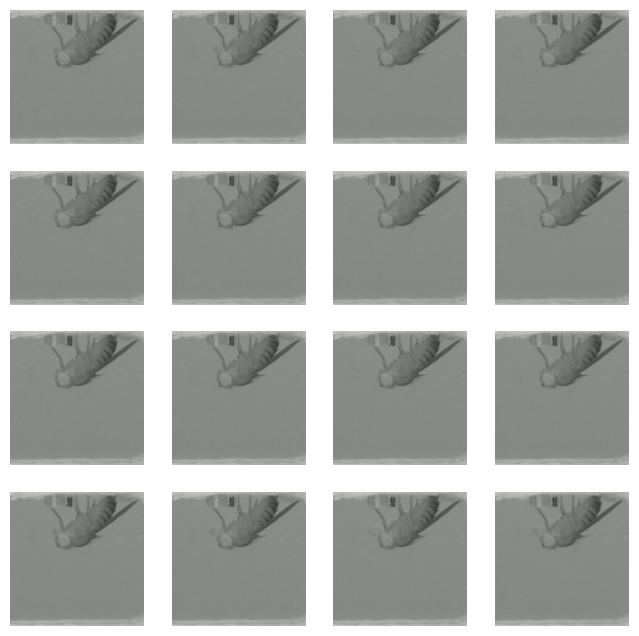

In [130]:
create_video_subplot(sample_video)